# Generating Samples 

In [1]:
import torch

# Check if CUDA is available and being used
cuda_available = torch.cuda.is_available()
current_device = torch.cuda.current_device() if cuda_available else 'CPU'
device_name = torch.cuda.get_device_name(current_device) if cuda_available else 'CPU'

print(f"CUDA Available: {cuda_available}")
print(f"Current Device: {current_device}")
print(f"Device Name: {device_name}")

CUDA Available: True
Current Device: 0
Device Name: NVIDIA TITAN X (Pascal)


In [2]:
import json

import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

from datasets import get_CIFAR10, get_SVHN, postprocess
from model import Glow

device = torch.device("cuda")

output_folder = 'output/'
# model_name = 'glow_model_250.pth'
ds_name = 'cifar10'  # 'svhn'

if ds_name == 'cifar10':
    model_name = 'glow_checkpoint_195250.pt'

    with open(output_folder + 'cifar10_hparams.json') as json_file:  
        hparams = json.load(json_file)

elif ds_name == 'svhn':
    model_name = 'glow_checkpoint_284856.pt'

    with open(output_folder + 'svhn_hparams.json') as json_file:  
        hparams = json.load(json_file)
    
image_shape, num_classes, _, test_cifar = get_CIFAR10(hparams['augment'], hparams['dataroot'], hparams['download'])
image_shape, num_classes, _, test_svhn = get_SVHN(hparams['augment'], hparams['dataroot'], hparams['download'])


model = Glow(image_shape, hparams['hidden_channels'], hparams['K'], hparams['L'], hparams['actnorm_scale'],
             hparams['flow_permutation'], hparams['flow_coupling'], hparams['LU_decomposed'], num_classes,
             hparams['learn_top'], hparams['y_condition'])

model.load_state_dict(torch.load(output_folder + model_name)['model']) # Load only model part
model.set_actnorm_init()

model = model.to(device)

model = model.eval()

/net/hcihome/storage/bmontaze/behrooz_vscode/repos/ood_detections/models/glow_model/modules.py:318: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2416.)
  w_init = torch.qr(torch.randn(*w_shape))[0]
/export/home/bmontaze/behrooz_vscode/repos/ood_detections/.venv/lib/python3.10/site-packages/torch/functional.py:1924: UserWarning: torch.lu is deprecated in favor of torch.linalg.lu_factor / torch.linalg.lu_factor_ex and will be removed in a future PyTorch release.
LU, pivots = torch.lu(A, compute_pivots)
should be replaced with
LU, pivots = torch.linalg.lu_factor(A, compute_pivots)
and
LU, pivots, info = torch.lu(A, compute_pivots, get_infos=True)
should be replaced 

In [4]:
# Check what keys are present in the checkpoint
# checkpoint = torch.load(output_folder + model_name, map_location=device)
# print(checkpoint.keys())  


/tmp/ipykernel_3165091/1229722888.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(output_folder + model_name, map_location=device)


dict_keys(['model', 'optimizer'])


In [3]:
def sample(model):
    with torch.no_grad():
        if hparams['y_condition']:
            y = torch.eye(num_classes)
            y = y.repeat(batch_size // num_classes + 1)
            y = y[:32, :].to(device) # number hardcoded in model for now
        else:
            y = None

        images = postprocess(model(y_onehot=y, temperature=1, reverse=True))

    return images.cpu()

(-0.5, 171.5, 171.5, -0.5)

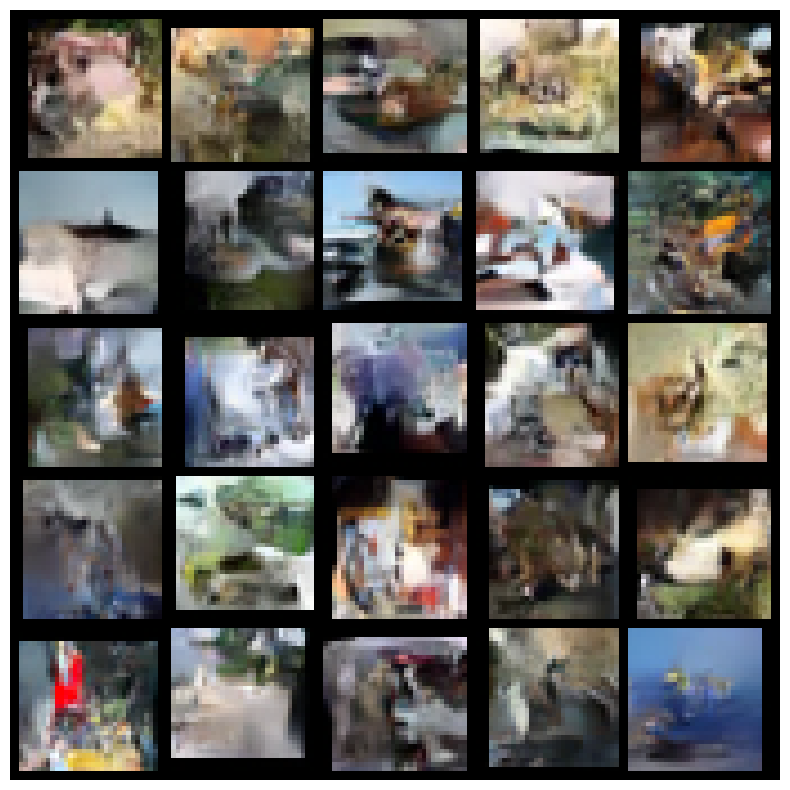

In [4]:
images = sample(model)
grid = make_grid(images[:25], nrow=5).permute(1,2,0)

plt.figure(figsize=(10,10))
plt.imshow(grid)
plt.axis('off')

# Gradient Features

In [3]:
def gradient_features(model, inputs):
    
    # Set the model to evaluation mode
    model = model.to(device).eval()
    inputs = inputs.to(device)

    # Reset gradients
    model.zero_grad()
    # Enable gradient tracking
    inputs.requires_grad = True

    # Forward pass through the model
    outputs = model(inputs)
    # print(f"{outputs= }")
    
    # If the model outputs a tuple (e.g., logits, auxiliary outputs), extract the logits
    if isinstance(outputs, tuple):
        log_likelihoods = outputs[0]  # Assuming the first element is the relevant output (logits or likelihood)
    else:
        log_likelihoods = outputs  # If it's not a tuple, directly use the output
    # print(f"{log_likelihoods= }")
    # Sum the log-likelihoods to compute the total loss
    loss = torch.sum(log_likelihoods)
    # print(f"{loss= }")
    # Backpropagate to compute gradients
    loss.backward()

    # Calculate layer-wise squared L2 norms of gradients and keep track of the number of features
    features_scalar = []
    features = []
    num_features = []
    for param in model.parameters():
        if param.grad is not None:
            # Layer-wise L2 norm of gradients
            squared_layer_norm = torch.norm(param.grad)**2
            features.append(squared_layer_norm)  # Store the layer-wise norm
            features_scalar.append(squared_layer_norm.item())  # Convert to a scalar and store
            num_features.append(param.grad.numel())  # Store the number of features

    return features, num_features, features_scalar


In [7]:
# for i, param in enumerate(model.parameters()):
#     if param.grad is not None and i <= 2:
#         print(param.grad.shape)
#         print(param.grad)
#     # break


# Fit Guassians to Log_features

In [4]:
from torch.utils.data import DataLoader, Subset
import random
# Randomly select 1000 samples from the fit dataset
num_samples = 100
batch_size = 5
random_indices = random.sample(range(len(test_cifar)), num_samples)

# Create a subset of the fit_dataset using the random indices
fit_subset = Subset(test_cifar, random_indices)

# Create a DataLoader for the subset
fit_loader = DataLoader(fit_subset, batch_size=batch_size, shuffle=False)

# # Define DataLoader for the test set
# fit_loader = DataLoader(test_cifar, batch_size=batch_size, shuffle=False)

# Get a batch of 5 samples from the test DataLoader
fit_samples, labels = next(iter(fit_loader))  # Retrieve a batch of inputs and labels
# inputs = inputs.to(device)  # Move inputs to the correct device (GPU or CPU)

# Now you can pass the inputs to your gradient_features function
features, num_gradients_in_layers, features_scalar = gradient_features(model, fit_samples)


In [5]:
fit_samples.shape

torch.Size([5, 3, 32, 32])

In [6]:
import torch

def fit_gaussians_to_log_features(model, fit_loader, device):
    model.eval()  # Set model to evaluation mode

    # Initialize a list to hold log features for each layer
    # Use a list of tensors initialized with empty tensors to accumulate log features
    all_features = None

    # Loop through batches in the fit dataset
    for inputs, _ in fit_loader:
        inputs = inputs.to(device)

        # Get the gradient features for the batch
        features, _, _ = gradient_features(model, inputs)

        # Take the log of each feature in the batch
        log_features = [torch.log(f + 1e-10) for f in features]  # Add small value to avoid log(0)

        # If all_features is None, initialize it with the first batch's log features
        if all_features is None:
            all_features = [f.unsqueeze(0) for f in log_features]  # Start a new list of tensors
        else:
            # Concatenate the new log features with existing ones for each layer
            for i in range(len(all_features)):
                all_features[i] = torch.cat((all_features[i], log_features[i].unsqueeze(0)), dim=0)

    # Initialize lists to store Gaussian parameters for each layer
    means = []
    variances = []

    # Iterate over layers to calculate mean and variance
    for layer_features in all_features:
        # Compute mean and variance across batches
        layer_mean = torch.mean(layer_features, dim=0)
        layer_variance = torch.var(layer_features, dim=0)

        # Append as tensors to means and variances
        means.append(layer_mean.detach())  # Detach to avoid gradient tracking
        variances.append(layer_variance.detach())

    return means, variances, all_features

# Fit Gaussians to the log of the gradient features
means, variances, all_features = fit_gaussians_to_log_features(model, fit_loader, device)


In [8]:
variances

[tensor(2.2457, device='cuda:0'),
 tensor(1.3506, device='cuda:0'),
 tensor(1.6806, device='cuda:0'),
 tensor(1.6733, device='cuda:0'),
 tensor(1.7216, device='cuda:0'),
 tensor(0.6189, device='cuda:0'),
 tensor(1.7203, device='cuda:0'),
 tensor(1.8921, device='cuda:0'),
 tensor(0.9104, device='cuda:0'),
 tensor(1.4914, device='cuda:0'),
 tensor(0.7388, device='cuda:0'),
 tensor(1.8904, device='cuda:0'),
 tensor(0.3314, device='cuda:0'),
 tensor(2.0588, device='cuda:0'),
 tensor(2.0849, device='cuda:0'),
 tensor(1.5013, device='cuda:0'),
 tensor(1.7060, device='cuda:0'),
 tensor(1.2537, device='cuda:0'),
 tensor(2.1449, device='cuda:0'),
 tensor(0.5486, device='cuda:0'),
 tensor(0.4947, device='cuda:0'),
 tensor(0.7231, device='cuda:0'),
 tensor(0.4024, device='cuda:0'),
 tensor(0.3265, device='cuda:0'),
 tensor(0.4753, device='cuda:0'),
 tensor(1.6139, device='cuda:0'),
 tensor(0.8855, device='cuda:0'),
 tensor(2.7636, device='cuda:0'),
 tensor(2.8481, device='cuda:0'),
 tensor(0.6269

# OOD Score

In [7]:
import torch
import numpy as np

def gaussian_negative_log_likelihood(log_features, means, variances):
    ood_scores = []

    # Iterate over each layer's features, means, and variances
    for layer_features, mu, sigma2 in zip(log_features, means, variances):
        # Ensure mu and sigma2 are tensors and have the correct shape
        mu = mu.to(layer_features.device)
        sigma2 = sigma2.to(layer_features.device)

        # Reshape sigma2 to allow broadcasting
        if sigma2.dim() == 1:
            sigma2 = sigma2.view(1, -1)  # Shape (1, num_features)

        # Compute the negative log-likelihood for the layer
        epsilon = 1e-10
        nll = 0.5 * torch.sum(((layer_features - mu) ** 2) / (sigma2+epsilon) + torch.log(2 * torch.pi * (sigma2+epsilon)), dim=0)
        ood_scores.append(nll)
        # print(f"{nll= }")

    # Sum over all layers to get the final OOD score for each sample
    # sfeatures = torch.stack(ood_scores)
    # print(f"{sfeatures.shape},\n {sfeatures= }")
    # print(f"{ood_scores= }")
    
    return torch.sum(torch.stack(ood_scores))

def ood_score_for_batch(model, new_samples, means, variances, device):
    # model.to(device)
    model.eval()  # Set model to evaluation mode

    # Compute the gradient features for the new batch
    features, _, _ = gradient_features(model, new_samples)

    # Take the log of each feature in the batch
    log_features = [torch.log(f + 1e-10) for f in features]  # Add small value to avoid log(0)
    # print(f"{log_features= }")

    # Compute OOD score using Gaussian negative log-likelihood
    ood_scores = gaussian_negative_log_likelihood(log_features, means, variances)

    return ood_scores



In [17]:
# Randomly select 1000 samples from a dataset
model = model.to(device)
num_samples = 1000
batch_size = 5
random_indices_test = random.sample(range(len(test_svhn)), num_samples)

# Create a subset of the fit_dataset using the random indices
test_subset = Subset(test_svhn, random_indices_test)

# Create a DataLoader for the subset
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

test_samples, _ = next(iter(test_loader))  # Get a new batch of samples
test_samples = test_samples.to(device)
# Compute the OOD scores for the batch
ood_scores_test_samples = ood_score_for_batch(model, test_samples, means, variances, device)

ood_scores_fit_samples = ood_score_for_batch(model, fit_samples, means, variances, device)
# The 'ood_scores' tensor will contain the OOD score for each sample in the batch.
print(f"{ood_scores_test_samples=}")
print(f"{ood_scores_fit_samples=}")


ood_scores_test_samples=tensor(1372.3103, device='cuda:0')
ood_scores_fit_samples=tensor(-651.3186, device='cuda:0')


# Plots of Means and Variances

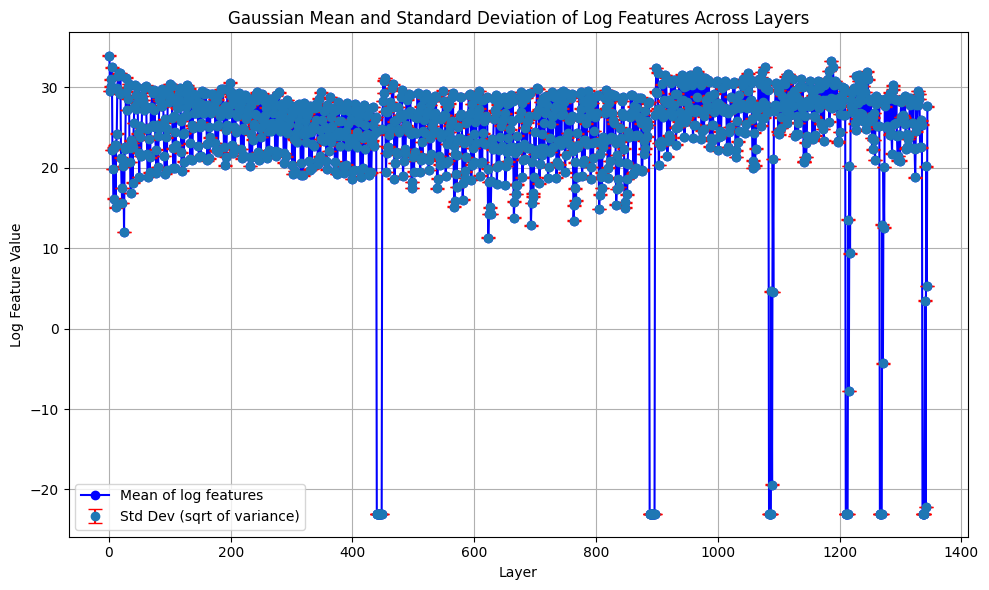

In [46]:
import numpy as np
import matplotlib.pyplot as plt

def plot_gaussians(means, variances, layer_labels=None):
    """
    Plots the Gaussian mean and variance for each layer's log features.
    
    Args:
    - means: List of mean values for each layer.
    - variances: List of variance values for each layer.
    - layer_labels: List of layer labels or indices. Optional.
    """
    num_layers = len(means)
    layers = np.arange(1, num_layers + 1) if layer_labels is None else layer_labels

    # Convert variances to standard deviations
    std_devs = [np.sqrt(var) for var in variances]

    # Plot the means and standard deviations
    plt.figure(figsize=(10, 6))

    # Plot the mean of log features for each layer
    plt.plot(layers, means, label='Mean of log features', color='b', marker='o')

    # Plot the variance (as standard deviation) of log features for each layer
    plt.errorbar(layers, means, yerr=std_devs, fmt='o', ecolor='r', capsize=5, label='Std Dev (sqrt of variance)')

    # Labels and title
    plt.xlabel("Layer")
    plt.ylabel("Log Feature Value")
    plt.title("Gaussian Mean and Standard Deviation of Log Features Across Layers")
    plt.legend()

    # Optionally, set layer indices as x-ticks
    if layer_labels:
        plt.xticks(layers, layer_labels, rotation=45)

    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage:
# Assume 'means' and 'variances' are already computed from the previous steps
plot_gaussians(means, variances)


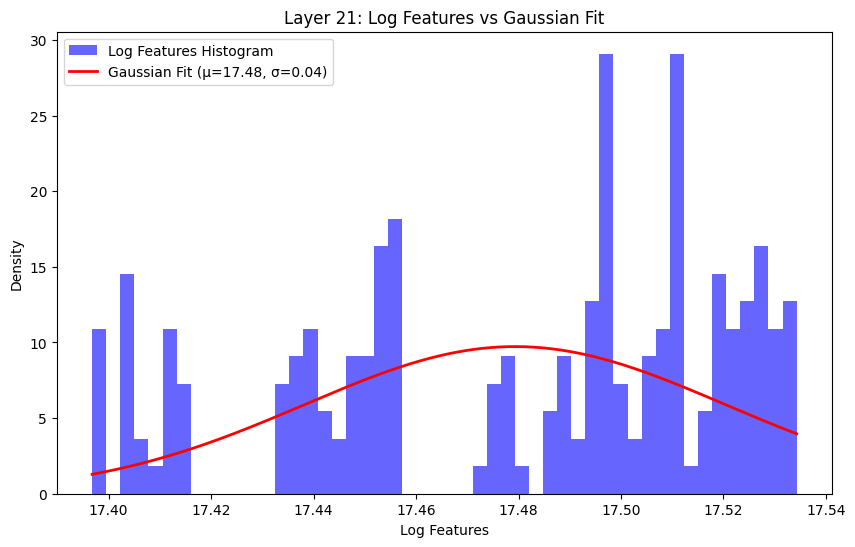

In [55]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

def plot_gaussian_with_histogram(log_features, means, variances, layer_idx):
    """
    Plot histogram of log features with the fitted Gaussian overlaid.
    
    Parameters:
        log_features (Tensor): Log-transformed features for a specific layer.
        means (list): Mean of the Gaussian for each layer.
        variances (list): Variance of the Gaussian for each layer.
        layer_idx (int): Index of the layer to plot.
    """
    log_features_np = log_features.cpu().numpy().flatten()  # Convert to NumPy array and flatten for plotting
    
    # Compute the Gaussian curve based on the mean and variance
    mu = means[layer_idx]
    sigma = np.sqrt(variances[layer_idx])
    
    # Define the range for plotting the Gaussian curve
    x_min = np.min(log_features_np)
    x_max = np.max(log_features_np)
    x_range = np.linspace(x_min, x_max, 1000)
    gaussian_curve = norm.pdf(x_range, mu, sigma)

    # Create the histogram for the log features
    plt.figure(figsize=(10, 6))
    plt.hist(log_features_np, bins=50, density=True, alpha=0.6, color='blue', label='Log Features Histogram')
    
    # Plot the Gaussian curve
    plt.plot(x_range, gaussian_curve, 'r-', label=f'Gaussian Fit (μ={mu:.2f}, σ={sigma:.2f})', lw=2)

    # Labels and title
    plt.xlabel('Log Features')
    plt.ylabel('Density')
    plt.title(f'Layer {layer_idx + 1}: Log Features vs Gaussian Fit')
    plt.legend()
    
    # Show the plot
    plt.show()

# Example usage (assuming log_features, means, and variances are already computed):

# Layer index to plot (e.g., 0 for the first layer)
layer_idx = 20

# Plot the histogram and Gaussian fit for layer 0
plot_gaussian_with_histogram(all_features[layer_idx], means, variances, layer_idx)


In [57]:
all_features[20]

tensor([17.3973, 17.3971, 17.3968, 17.3970, 17.3973, 17.3972, 17.4048, 17.4044,
        17.4038, 17.4045, 17.4045, 17.4038, 17.4040, 17.4029, 17.4063, 17.4061,
        17.4093, 17.4115, 17.4132, 17.4127, 17.4128, 17.4126, 17.4141, 17.4129,
        17.4135, 17.4140, 17.4147, 17.4344, 17.4334, 17.4333, 17.4341, 17.4354,
        17.4368, 17.4369, 17.4367, 17.4366, 17.4389, 17.4395, 17.4393, 17.4402,
        17.4417, 17.4409, 17.4399, 17.4407, 17.4408, 17.4439, 17.4478, 17.4462,
        17.4465, 17.4469, 17.4484, 17.4501, 17.4501, 17.4511, 17.4516, 17.4528,
        17.4546, 17.4512, 17.4481, 17.4540, 17.4541, 17.4542, 17.4540, 17.4542,
        17.4539, 17.4544, 17.4545, 17.4560, 17.4562, 17.4562, 17.4561, 17.4561,
        17.4552, 17.4558, 17.4559, 17.4560, 17.4728, 17.4749, 17.4749, 17.4748,
        17.4746, 17.4767, 17.4767, 17.4768, 17.4772, 17.4775, 17.4801, 17.4863,
        17.4866, 17.4868, 17.4897, 17.4896, 17.4898, 17.4894, 17.4889, 17.4944,
        17.4927, 17.4926, 17.4932, 17.49

# Ploting

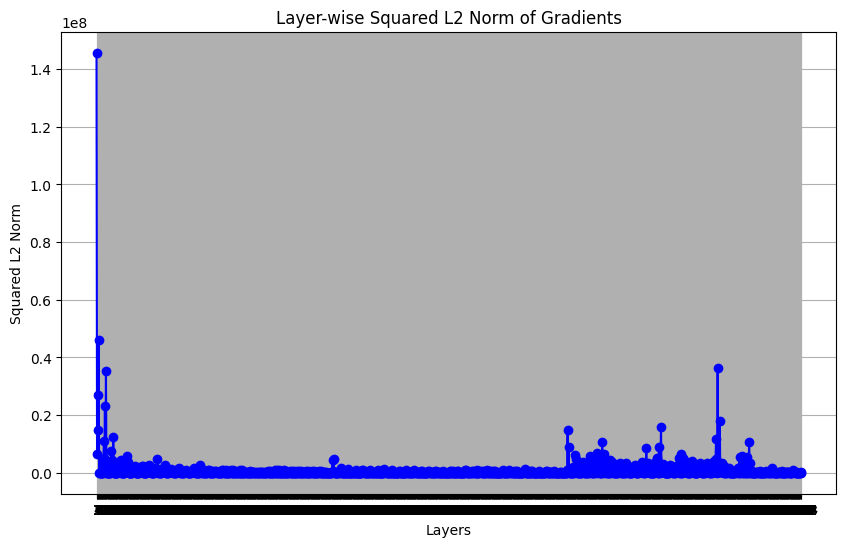

In [9]:
import matplotlib.pyplot as plt

# Assuming `features` is the list or tensor of layer-wise L2 norms returned by gradient_features function
def plot_layer_wise_features(features):
    # Number of layers (same as the number of features)
    num_layers = len(features)

    # Create a range for the layers
    layers = range(1, num_layers + 1)

    # Plotting the features
    plt.figure(figsize=(10, 6))  # Set the figure size
    plt.plot(layers, features, marker='o', linestyle='-', color='b')  # Line plot with markers
    plt.title('Layer-wise Squared L2 Norm of Gradients')
    plt.xlabel('Layers')
    plt.ylabel('Squared L2 Norm')
    plt.xticks(layers)  # Set x-axis ticks to be the layer numbers
    plt.grid(True)  # Add a grid for easier visualization
    plt.show()  # Display the plot

# Plot the layer-wise features
plot_layer_wise_features(features_scalar)  


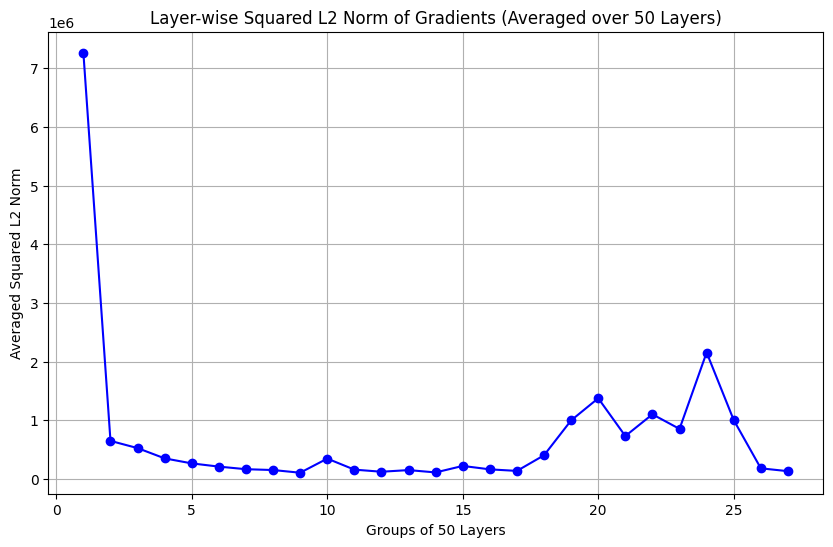

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plot_layer_wise_features(features, group_size=50):
    # Group layers by averaging every `group_size` layers
    num_layers = len(features)
    grouped_features = [
        np.mean(features[i:i + group_size]) for i in range(0, num_layers, group_size)
    ]
    
    # Corresponding layer indices
    grouped_layers = range(1, len(grouped_features) + 1)

    # Plotting the features
    plt.figure(figsize=(10, 6))
    plt.plot(grouped_layers, grouped_features, marker='o', linestyle='-', color='b')
    plt.title(f'Layer-wise Squared L2 Norm of Gradients (Averaged over {group_size} Layers)')
    plt.xlabel(f'Groups of {group_size} Layers')
    plt.ylabel('Averaged Squared L2 Norm')
    plt.grid(True)
    plt.show()

 # Average every 50 layers
plot_layer_wise_features(features_scalar, group_size=50) 


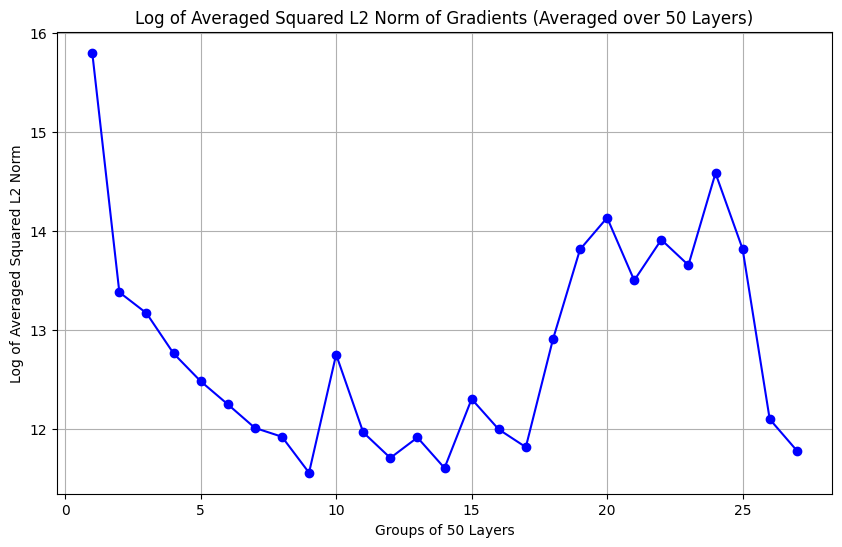

In [11]:
def plot_layer_wise_features_log_avg(features, group_size=50):
    # Group layers by averaging every `group_size` layers
    num_layers = len(features)
    grouped_features = [
        np.mean(features[i:i + group_size]) for i in range(0, num_layers, group_size)
    ]
    
    # Apply logarithmic scaling
    log_grouped_features = np.log1p(grouped_features)  # Using log1p for numerical stability (log(1+x))

    # Corresponding layer indices
    grouped_layers = range(1, len(log_grouped_features) + 1)

    # Plotting with logarithmic scaling on y-axis
    plt.figure(figsize=(10, 6))
    plt.plot(grouped_layers, log_grouped_features, marker='o', linestyle='-', color='b')
    plt.title(f'Log of Averaged Squared L2 Norm of Gradients (Averaged over {group_size} Layers)')
    plt.xlabel(f'Groups of {group_size} Layers')
    plt.ylabel('Log of Averaged Squared L2 Norm')
    plt.grid(True)
    plt.show()

# Example usage
plot_layer_wise_features_log_avg(features_scalar, group_size=50)


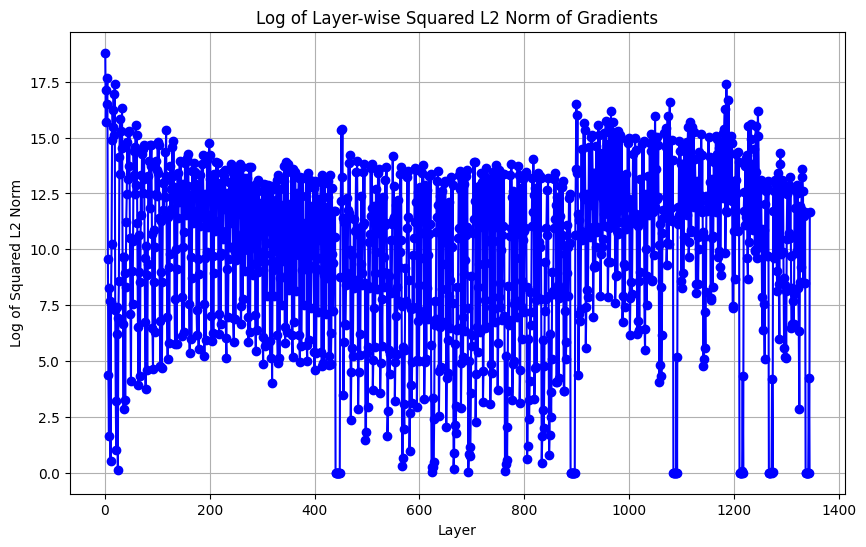

In [12]:
def plot_layer_wise_features_log(features):
    # Apply logarithmic scaling directly to features
    log_features = np.log1p(features)  # Using log1p for numerical stability

    # Layer indices
    layers = range(1, len(log_features) + 1)

    # Plotting the features
    plt.figure(figsize=(10, 6))
    plt.plot(layers, log_features, marker='o', linestyle='-', color='b')
    plt.title(f'Log of Layer-wise Squared L2 Norm of Gradients')
    plt.xlabel('Layer')
    plt.ylabel('Log of Squared L2 Norm')
    plt.grid(True)
    plt.show()

# Example usage
plot_layer_wise_features_log(features_scalar)



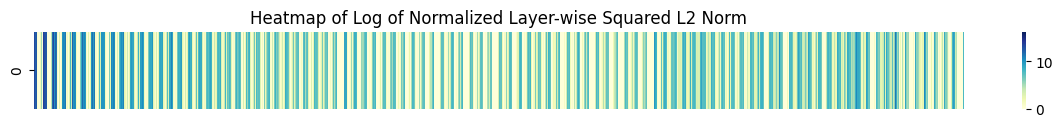

In [13]:
import seaborn as sns

def plot_layer_wise_heatmap_log(features, num_gradients_in_layers):
    # Normalize the features based on num_gradients_in_layers
    normalized_features = [f / n for f, n in zip(features, num_gradients_in_layers)]
    
    # Apply logarithmic scaling
    log_features = np.log1p(normalized_features)  # Using log1p for numerical stability
 
    # Convert features to 2D array for heatmap (assuming 1D)
    heatmap_data = np.array(log_features).reshape(1, -1)

    # Plotting heatmap
    plt.figure(figsize=(15, 1))
    sns.heatmap(heatmap_data, cmap="YlGnBu", cbar=True, xticklabels=False)
    plt.title(f'Heatmap of Log of Normalized Layer-wise Squared L2 Norm')
    plt.show()

# Example usage
plot_layer_wise_heatmap_log(features_scalar, num_gradients_in_layers)

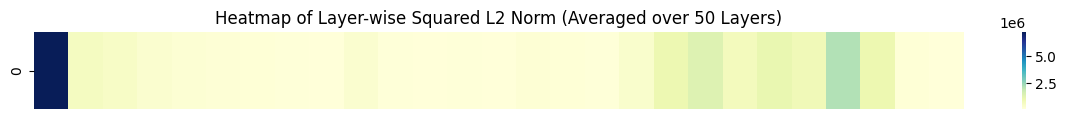

In [14]:
def plot_layer_wise_heatmap(features, group_size=50):
    # Group layers by averaging every `group_size` layers
    num_layers = len(features)
    grouped_features = [
        np.mean(features[i:i + group_size]) for i in range(0, num_layers, group_size)
    ]
    
    # Convert features to 2D array for heatmap (assuming 1D)
    heatmap_data = np.array(grouped_features).reshape(1, -1)

    # Plotting heatmap
    plt.figure(figsize=(15, 1))
    sns.heatmap(heatmap_data, cmap="YlGnBu", cbar=True, xticklabels=False)
    plt.title(f'Heatmap of Layer-wise Squared L2 Norm (Averaged over {group_size} Layers)')
    plt.show()

# Example usage
plot_layer_wise_heatmap(features_scalar, group_size=50)


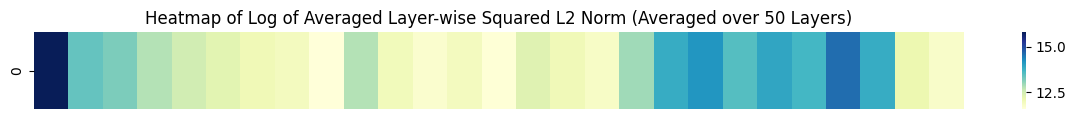

In [15]:
def plot_layer_wise_heatmap_log(features, group_size=50):
    # Group layers by averaging every `group_size` layers
    num_layers = len(features)
    grouped_features = [
        np.mean(features[i:i + group_size]) for i in range(0, num_layers, group_size)
    ]
    
    # Apply logarithmic scaling
    log_grouped_features = np.log1p(grouped_features)  # Using log1p for numerical stability

    # Convert features to 2D array for heatmap (assuming 1D)
    heatmap_data = np.array(log_grouped_features).reshape(1, -1)

    # Plotting heatmap
    plt.figure(figsize=(15, 1))
    sns.heatmap(heatmap_data, cmap="YlGnBu", cbar=True, xticklabels=False)
    plt.title(f'Heatmap of Log of Averaged Layer-wise Squared L2 Norm (Averaged over {group_size} Layers)')
    plt.show()

# Example usage
plot_layer_wise_heatmap_log(features_scalar, group_size=50)


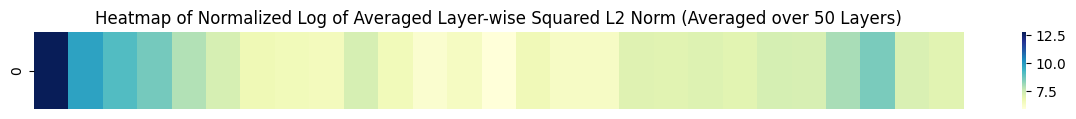

In [16]:
def plot_layer_wise_heatmap_log(features, num_gradients_in_layers, group_size=50):
    # Group layers by averaging every `group_size` layers
    num_layers = len(features)
    normalized_features = [f / n for f, n in zip(features, num_gradients_in_layers)]
    grouped_features = [
        np.mean(normalized_features[i:i + group_size]) for i in range(0, num_layers, group_size)
    ]
    
    # Apply logarithmic scaling
    log_grouped_features = np.log1p(grouped_features)  # Using log1p for numerical stability

    # Convert features to 2D array for heatmap (assuming 1D)
    heatmap_data = np.array(log_grouped_features).reshape(1, -1)

    # Plotting heatmap
    plt.figure(figsize=(15, 1))
    sns.heatmap(heatmap_data, cmap="YlGnBu", cbar=True, xticklabels=False)
    plt.title(f'Heatmap of Normalized Log of Averaged Layer-wise Squared L2 Norm (Averaged over {group_size} Layers)')
    plt.show()

# Example usage
plot_layer_wise_heatmap_log(features_scalar, num_gradients_in_layers, group_size=50)

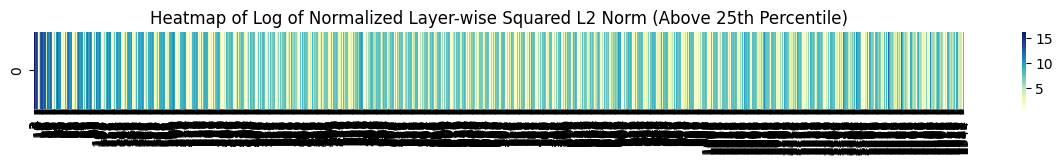

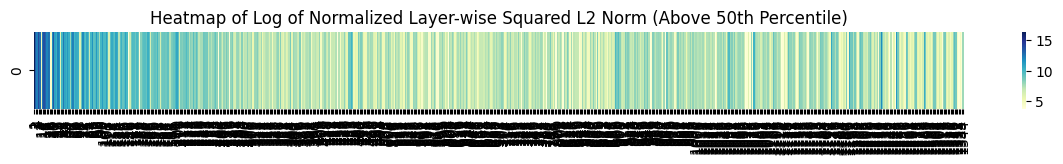

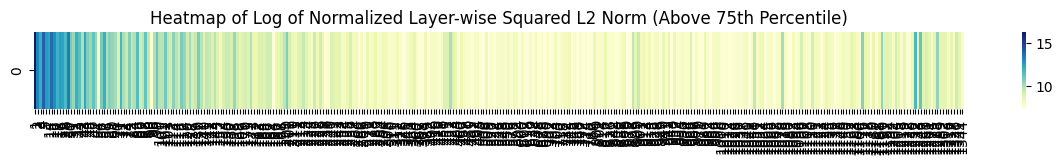

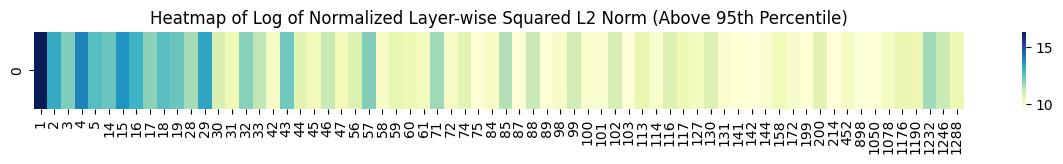

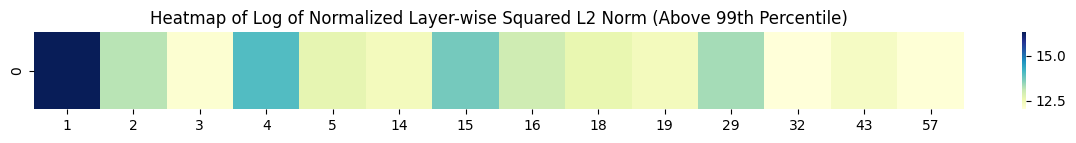

In [17]:
def plot_percentile_heatmap(features, num_gradients_in_layers, percentiles = [25, 50, 75, 95, 99]):
    # Normalize the features based on num_gradients_in_layers
    normalized_features = [f / n for f, n in zip(features, num_gradients_in_layers)]
    
    # Apply logarithmic scaling
    log_features = np.log1p(normalized_features)  # Using log1p for numerical stability

    percentiles = percentiles
    thresholds = np.percentile(log_features, percentiles)
    filtered_features = {p: [(i+1, f) for i, f in enumerate(log_features) if f > t] for p, t in zip(percentiles, thresholds)}
    for p, features in filtered_features.items():
        if features:
            layer_positions, filtered_features = zip(*features)
            heatmap_data = np.array(filtered_features).reshape(1, -1)
            
            plt.figure(figsize=(15, 1))
            sns.heatmap(heatmap_data, cmap="YlGnBu", cbar=True, xticklabels=layer_positions)
            plt.title(f'Heatmap of Log of Normalized Layer-wise Squared L2 Norm (Above {p}th Percentile)')
            plt.show()

# Example usage
plot_percentile_heatmap(features_scalar, num_gradients_in_layers, percentiles = [25, 50, 75, 95, 99])

# OOD Score